In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import imgaug as ia
import imgaug.augmenters as iaa

sns.set_style("whitegrid")

In [4]:
data = pd.read_csv("../data/data.csv")
del data["Unnamed: 0"]
data.shape

(4206, 4)

In [5]:
img_paths, y = [], []
for i in range(len(data)):
    p = f"../data/Images/{data.name[i]}"
    if os.path.exists(p) and data.is_training[i]:
        img_paths.append(p)
        y.append(data.bmi[i])

y = np.array(y)
len(img_paths), len(y)

(3210, 3210)

In [4]:
# images = [np.array(Image.open(p)) for p in img_paths]

In [6]:
low_bmi_paths = [p for i, p in enumerate(img_paths) if y[i] <= 20]
low_bmi_imgs = [np.array(Image.open(p)) for i, p in enumerate(img_paths) if y[i] <= 20]
low_bmi = [x for x in y if x <= 20]

mid_bmi_paths = [p for i, p in enumerate(img_paths) if y[i] > 20 and y[i] < 45]
mid_bmi_imgs = [np.array(Image.open(p)) for i, p in enumerate(img_paths) if y[i] > 20 and y[i] < 45]
mid_bmi = [x for x in y if x > 20 and x < 45]

high_bmi_paths = [p for i, p in enumerate(img_paths) if y[i] >= 45]
high_bmi_imgs = [np.array(Image.open(p)) for i, p in enumerate(img_paths) if y[i] >= 45]
high_bmi = [x for x in y if x >= 45]

len(low_bmi_imgs), len(mid_bmi_imgs), len(high_bmi_imgs)

(28, 2951, 231)

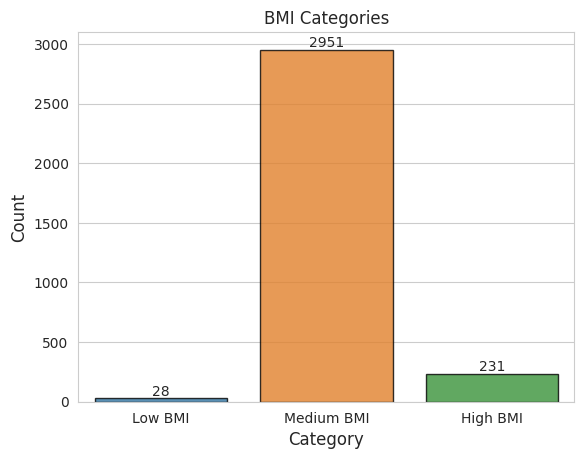

In [3]:
ax = sns.barplot(x=["Low BMI", "Medium BMI", "High BMI"], y=[28, 2951, 231], alpha=0.8, edgecolor='k')
ax.bar_label(ax.containers[0])

plt.title('BMI Categories')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [7]:
def get_new_images(images, seed):
    ia.seed(seed)
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Crop(percent=(0, 0.1)),
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True)

    return seq(images=images)

In [10]:
low_bmi_paths_copy = low_bmi_paths.copy()
low_bmi_imgs_copy = low_bmi_imgs.copy()
low_bmi_copy = low_bmi.copy()
for i in tqdm(range(20)):
    aug_imgs = get_new_images(low_bmi_imgs_copy, i)
    low_bmi_paths += [x.replace(".bmp", f"_{i}.bmp") for x in low_bmi_paths_copy]
    low_bmi_imgs += aug_imgs
    low_bmi += low_bmi_copy

del low_bmi_paths_copy, low_bmi_imgs_copy, low_bmi_copy
len(low_bmi_paths), len(low_bmi_imgs), len(low_bmi)

  0%|          | 0/20 [00:00<?, ?it/s]

(588, 588, 588)

In [11]:
high_bmi_paths_copy = high_bmi_paths.copy()
high_bmi_imgs_copy = high_bmi_imgs.copy()
high_bmi_copy = high_bmi.copy()
for i in tqdm(range(5)):
    aug_imgs = get_new_images(high_bmi_imgs_copy, i)
    high_bmi_paths += [x.replace(".bmp", f"_{i}.bmp") for x in high_bmi_paths_copy]
    high_bmi_imgs += aug_imgs
    high_bmi += high_bmi_copy

del high_bmi_paths_copy, high_bmi_imgs_copy, high_bmi_copy
len(high_bmi_paths), len(high_bmi_imgs), len(high_bmi)

  0%|          | 0/5 [00:00<?, ?it/s]

(1386, 1386, 1386)

In [12]:
paths = low_bmi_paths + mid_bmi_paths + high_bmi_paths
images = low_bmi_imgs + mid_bmi_imgs + high_bmi_imgs
bmi = low_bmi + mid_bmi + high_bmi

len(paths), len(images), len(bmi)

(4925, 4925, 4925)

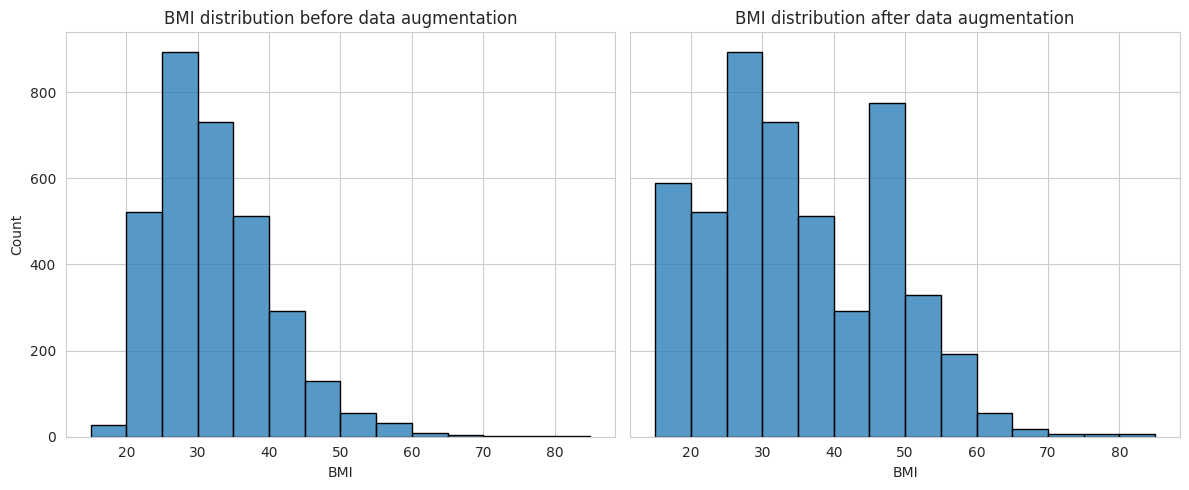

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(data=y, bins=np.arange(15, 90, 5), ax=axes[0], edgecolor="k")
sns.histplot(data=bmi, bins=np.arange(15, 90, 5), ax=axes[1], edgecolor="k")

axes[0].set_title("BMI distribution before data augmentation")
axes[1].set_title("BMI distribution after data augmentation")

axes[0].set_xlabel("BMI")
axes[1].set_xlabel("BMI")
axes[0].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [17]:
data.head()

,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp


In [19]:
df = pd.DataFrame(columns=["bmi", "is_training", "name"])

for i in tqdm(range(len(images))):
    p = paths[i].replace("Images", "Augmented-Images")
    if not os.path.exists(p):
        im = Image.fromarray(images[i])
        im.save(p, format="bmp")
    
    df.loc[i, "bmi"] = bmi[i]
    df.loc[i, "is_training"] = 1
    df.loc[i, "name"] = p.split("/")[-1]

  0%|          | 0/4925 [00:00<?, ?it/s]

In [20]:
df.head()

,bmi,is_training,name
0,19.366391,1,img_161.bmp
1,19.575629,1,img_267.bmp
2,17.718967,1,img_287.bmp
3,19.90918,1,img_423.bmp
4,19.966864,1,img_727.bmp


In [21]:
df = pd.concat([df, data[data.is_training == False][["bmi", "is_training", "name"]]])
df.reset_index(drop=True, inplace=True)
df.shape

(5763, 3)

In [22]:
df.name.unique().shape

(5763,)

In [23]:
df.is_training.value_counts()

1    4925
0     838
Name: is_training, dtype: int64

In [24]:
data.is_training.value_counts()

1    3368
0     838
Name: is_training, dtype: int64

In [25]:
df.to_csv("../data/augmented-data.csv", index=False)

In [31]:
for i in tqdm(range(len(df))):
    if df.is_training[i] == False and os.path.exists(f"../data/Images/{df.name[i]}"):
        _ = os.system(f"cp ../data/Images/{df.name[i]} ../data/Augmented-Images/")

  0%|          | 0/5763 [00:00<?, ?it/s]

In [26]:
!ls ../data/Augmented-Images | wc -l

5672


In [18]:
!ls ../data/Augmented-Images | wc -l

5672


In [27]:
df.shape

(5763, 3)